## Task g
### Logistic regression with SGD

Frederik Rogge, Mouhammad Abu Rasheed and Homa Priya Tarigopula

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import numpy as np                                                                          
np.random.seed(100)


from models import *
from utils import *
from optimizers import *

In [2]:
def design_matrix(x_train, x_test):
    #now scale the data
    scaler = StandardScaler()
    scaler.fit(x_train)
    X_train_scaled = scaler.transform(x_train)
    X_test_scaled = scaler.transform(x_test)
    return X_train_scaled , X_test_scaled

### Own implementation 

We will first use our own implementation.

Test Accuracy : 
 [[0.92617606 0.92617606 0.92794597 0.94552088]
 [0.96839    0.96839    0.97893184 0.97189877]
 [0.9806707  0.98068623 0.98068623 0.97189877]
 [0.97366868 0.98068623 0.98068623 0.97365316]
 [0.97189877 0.97540755 0.97189877 0.9648657 ]
 [0.97012886 0.9595715  0.90338457 0.82088185]]
Test loss : 
 [[0.25593325 0.25497254 0.24626904 0.2190604 ]
 [0.08762608 0.08727401 0.09533215 0.17994078]
 [0.08495995 0.07602373 0.09310221 0.17992981]
 [0.13180133 0.07970046 0.09322993 0.17973735]
 [0.1379769  0.08825603 0.09659511 0.1815851 ]
 [0.31184717 0.31929661 0.47306885 0.44907066]]


<AxesSubplot:xlabel='Learning rate', ylabel='Accuracy'>

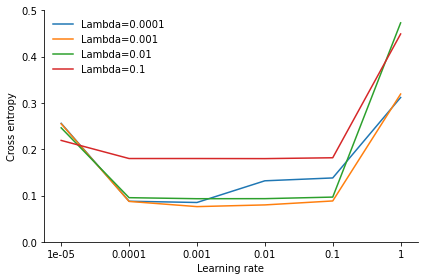

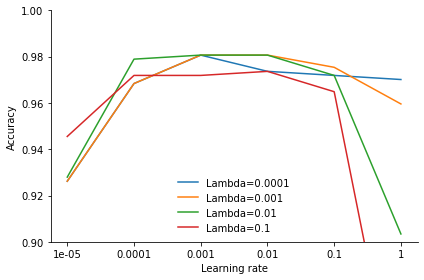

In [7]:
# Load the data
cancer = load_breast_cancer()
X, y =cancer.data, cancer.target

epochs = 1000

## Cross-validation based Logistic regression
ksplits = 5
kfold = KFold(n_splits = ksplits)
lr_eta = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
Lambdas = [1e-4, 1e-3, 1e-2, 1e-1]

est_test_acc = np.zeros((len(lr_eta), len(Lambdas) ))
est_test_loss = np.zeros((len(lr_eta), len(Lambdas) ))

for n_l, Lambda in  enumerate(Lambdas):
    for n_lr,lr in  enumerate(lr_eta):
        test_acc = np.zeros(ksplits)
        test_loss = np.zeros(ksplits)

        # Split the data into 5 folds and evaluate performance 
        for fold, (train_ind, test_ind) in enumerate(kfold.split(X)):
            X_train , X_test = X[train_ind], X[test_ind]
            y_train, y_test = y[train_ind], y[test_ind]

            # Create design matrix with standard scaling
            X_train_scaled, X_test_scaled  = design_matrix(X_train, X_test)


            logreg = LogisticRegression(fit_intercept=False,
                      dimension= X_train_scaled.shape[1],
                      random_init=True,
                      reduction='mean',
                      l2_reg =True,
                      lbd=Lambda)
                        
            optimizer = SGD(lr=lr)
            logreg.train(X_train_scaled, y_train, optimizer, batch_size=1, epochs=epochs)     

            # find accuracy on test set with beta_opt
            y_pred_prob = np.zeros((len(y_test),2))
            y_pred_prob[:,1] = logreg.predict(X_test_scaled)
            y_pred_prob[:,0] = 1-logreg.predict(X_test_scaled)

            test_acc[fold] = np.mean(np.argmax(y_pred_prob, axis=1)== y_test)
            test_loss[fold] = logreg.NLL_loss(X_test_scaled, y_test)
    
        est_test_acc[n_lr , n_l ] = np.mean(test_acc)
        est_test_loss[n_lr , n_l ] =  np.mean(test_loss)

print('Test Accuracy : \n', est_test_acc )
print('Test loss : \n', est_test_loss)

legend = ['Lambda={}'.format(lbd) for lbd in Lambdas]
plot_metric(y=est_test_loss.T, x=np.arange(len(lr_eta)), nx_ticks=lr_eta, save=True, x_label='Learning rate', y_label='Cross entropy', 
           name='g_own_test_loss', y_limit=[0, 0.5], legend=legend)
plot_metric(y=est_test_acc.T, x=np.arange(len(lr_eta)), nx_ticks=lr_eta, save=True, x_label='Learning rate', y_label='Accuracy', 
           name='g_own_test_accuracy', y_limit=[0.9, 1], legend=legend)

### Sklearn implementation

Here, we will use sklearn's implementation.

<AxesSubplot:xlabel='Learning rate', ylabel='Accuracy'>

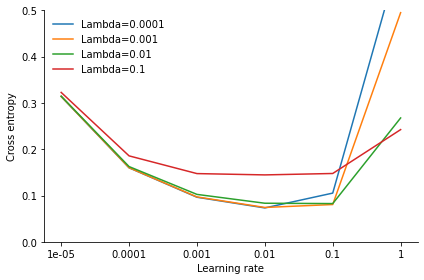

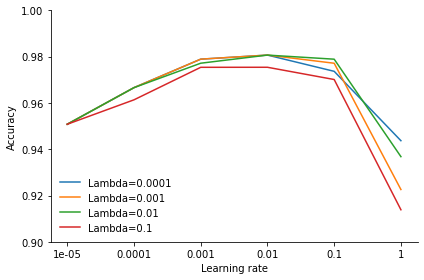

In [4]:
# Load the data
cancer = load_breast_cancer()
X, y =cancer.data, cancer.target

## Cross-validation based Logistic regression
ksplits = 5
kfold = KFold(n_splits = ksplits )
lr_eta = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
Lambdas = [1e-4, 1e-3, 1e-2, 1e-1]

est_test_acc = np.zeros((len(lr_eta), len(Lambdas) ))
est_test_loss = np.zeros((len(lr_eta), len(Lambdas) ))

for n_l, Lambda in  enumerate(Lambdas):
    for n_lr,lr in  enumerate(lr_eta):
        test_acc = np.zeros(ksplits)
        test_loss = np.zeros(ksplits)

        # Split the data into 5 folds and evaluate performance 
        for fold, (train_ind, test_ind) in enumerate(kfold.split(X)):
            X_train , X_test = X[train_ind], X[test_ind]
            y_train, y_test = y[train_ind], y[test_ind]

            # Create design matrix with standard scaling
            X_train_scaled, X_test_scaled  = design_matrix(X_train, X_test)

            SGD_logistic = SGDClassifier(loss='log', penalty='l2', alpha=Lambda, fit_intercept= False, max_iter=1000,  learning_rate='constant', eta0= lr )  # with cross validation
            SGD_logistic.fit(X_train_scaled, y_train)   

            test_acc[fold] =  SGD_logistic.score(X_test_scaled,y_test)
            test_loss[fold] = log_loss(y_test, SGD_logistic.predict_proba(X_test_scaled))
    
        est_test_acc[n_lr , n_l ] = np.mean(test_acc)
        est_test_loss[n_lr , n_l ] =  np.mean(test_loss)

legend = ['Lambda={}'.format(lbd) for lbd in Lambdas]
plot_metric(y=est_test_loss.T, x=np.arange(len(lr_eta)), nx_ticks=lr_eta, save=True, x_label='Learning rate', y_label='Cross entropy', 
           name='g_sklearn_test_loss', y_limit=[0, 0.5], legend=legend)
plot_metric(y=est_test_acc.T, x=np.arange(len(lr_eta)), nx_ticks=lr_eta, save=True, x_label='Learning rate', y_label='Accuracy', 
           name='g_sklearn_test_accuracy', y_limit=[0.9, 1], legend=legend)
